# Hello Polynomial Regression with Learning Curve Plots

In [1]:
# Prerequisites
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
print("Python Version: ", sys.version)
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
np.set_printoptions(precision=3, suppress=True)

Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Numpy Version:  2.2.2
Pandas Version:  2.2.3


### Generate some quadratic data samples with added random noise and plot

In [2]:
np.random.seed(73)
m = 200
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

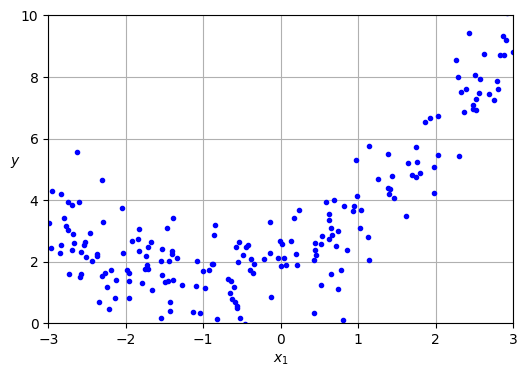

In [3]:
# Plot the synthetic data
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

## Solve using scikit learn Polynomial Features 

In [4]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [5]:
print(X_poly[0])

[0.856 0.733]


In [8]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

In [9]:
# Solution
print(f"scikit-learn solution, intercept = {lin_reg.intercept_},  coefficients = {lin_reg.coef_}")

scikit-learn solution, intercept = [1.936],  coefficients = [[1.021 0.509]]


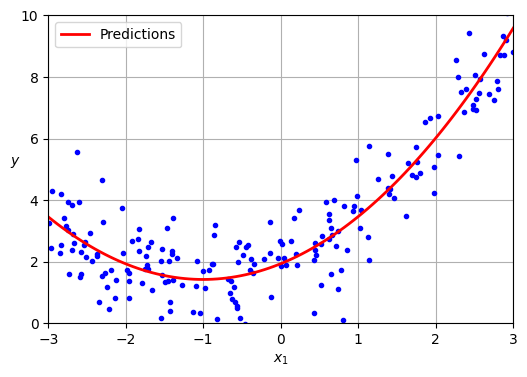

In [10]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

## Learning Curve

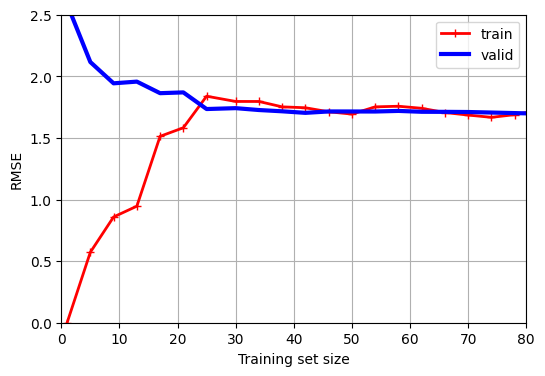

In [11]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4)) 
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])

plt.show()


These learning curves show underfitting. Both curves have reached a plateau, and they are close to each other and fairly high.

In [12]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

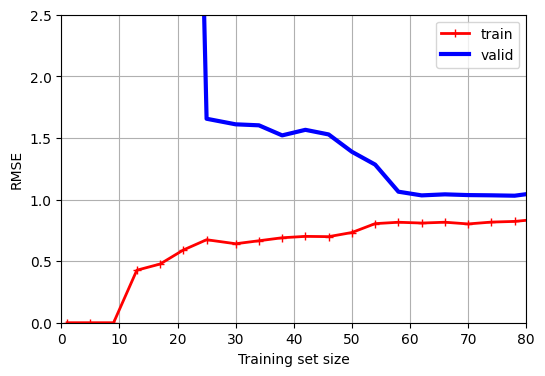

In [13]:
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

These learning curves show overfitting, model performs better with training data than validation data

## Early Stopping

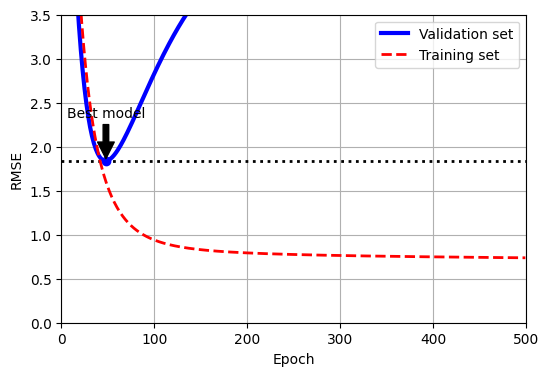

In [19]:
from copy import deepcopy
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# create the quadratic dataset with noise and split it
np.random.seed(73)
m = 200
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict)
    val_errors.append(val_error)
    train_errors.append(train_error)

# extra code – this section generates and saves Figure 4–20
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()

plt.show()